In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Classification Model

In [2]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

In [3]:
df = pd.read_csv('data/habitat-suitability.csv')

In [4]:
def classificationModel(labelled_df):

    X = labelled_df.drop('Suitable', axis=1)
    y = labelled_df['Suitable']

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)

    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)

    log_reg = LogisticRegression(random_state=42)
    log_reg.fit(X_train_scaled, y_train)

    y_pred = log_reg.predict(X_test_scaled)

    sample_accuracy = accuracy_score(y_test, y_pred)

    return sample_accuracy, log_reg, scaler

### **Baseline Model** (with full information)

In [5]:
baseline_accuracy, _, _ = classificationModel(df)

In [6]:
baseline_accuracy

0.8807

### **Random Active Learning**

In [7]:
# Average across seeds to get a more robust result:
tot_accuracies = []

for seed in range(1, 11):
    np.random.seed(seed)
    
    accuracies = {}

    # Initialize sample (stratified)
    _, current_sample = train_test_split(df, test_size=50, random_state=42, stratify=df['Suitable'])
    labelled_indexes = current_sample.index.tolist()

    step = 100

    for size in range(50, 9000, step):
        
        # Select labelled data and train model
        labelled_df = df.loc[labelled_indexes]
        sample_acc, model, scaler = classificationModel(labelled_df)

        # Predict on unlabelled data
        unlabelled_df = df.drop(labelled_indexes)
        
        full_X_train_scaled = scaler.fit_transform(unlabelled_df.drop('Suitable', axis=1))

        full_y_pred = model.predict(full_X_train_scaled)
        
        full_acc = accuracy_score(unlabelled_df['Suitable'], full_y_pred)

        # Store accuracies
        accuracies[size] = [sample_acc, full_acc]
        
        # Update sample 
        current_sample = df[~df.index.isin(labelled_indexes)].sample(n=step)

        labelled_indexes.extend(current_sample.index.tolist())

        tot_accuracies.append(accuracies)

In [8]:
list_of_dicts = tot_accuracies

sums = {key: (0, 0) for key in list_of_dicts[0].keys()}
# Initialize a dictionary to hold the count of entries for each key
counts = {key: 0 for key in list_of_dicts[0].keys()}

# Iterate over each dictionary and then each key to accumulate sums and counts
for d in list_of_dicts:
    for key, value_pair in d.items():
        # Sum the values for each key separately
        sums[key] = (sums[key][0] + value_pair[0], sums[key][1] + value_pair[1])
        # Increment the count for each key
        counts[key] += 1

# Calculate the average for each key
averages = {key: ((sums[key][0] / counts[key]), (sums[key][1] / counts[key])) for key in sums.keys()}

In [14]:
accuracies_df = pd.DataFrame(averages).T
accuracies_df.columns = ['Sample Accuracy', 'Full Accuracy']
accuracies_df

,Sample Accuracy,Full Accuracy
50,0.666667,0.827514
150,0.837778,0.854855
250,0.830667,0.860838
350,0.856190,0.868042
450,0.847407,0.867330
...,...,...
8550,0.880702,0.880102
8650,0.879461,0.880096
8750,0.878971,0.880313
8850,0.879548,0.880257


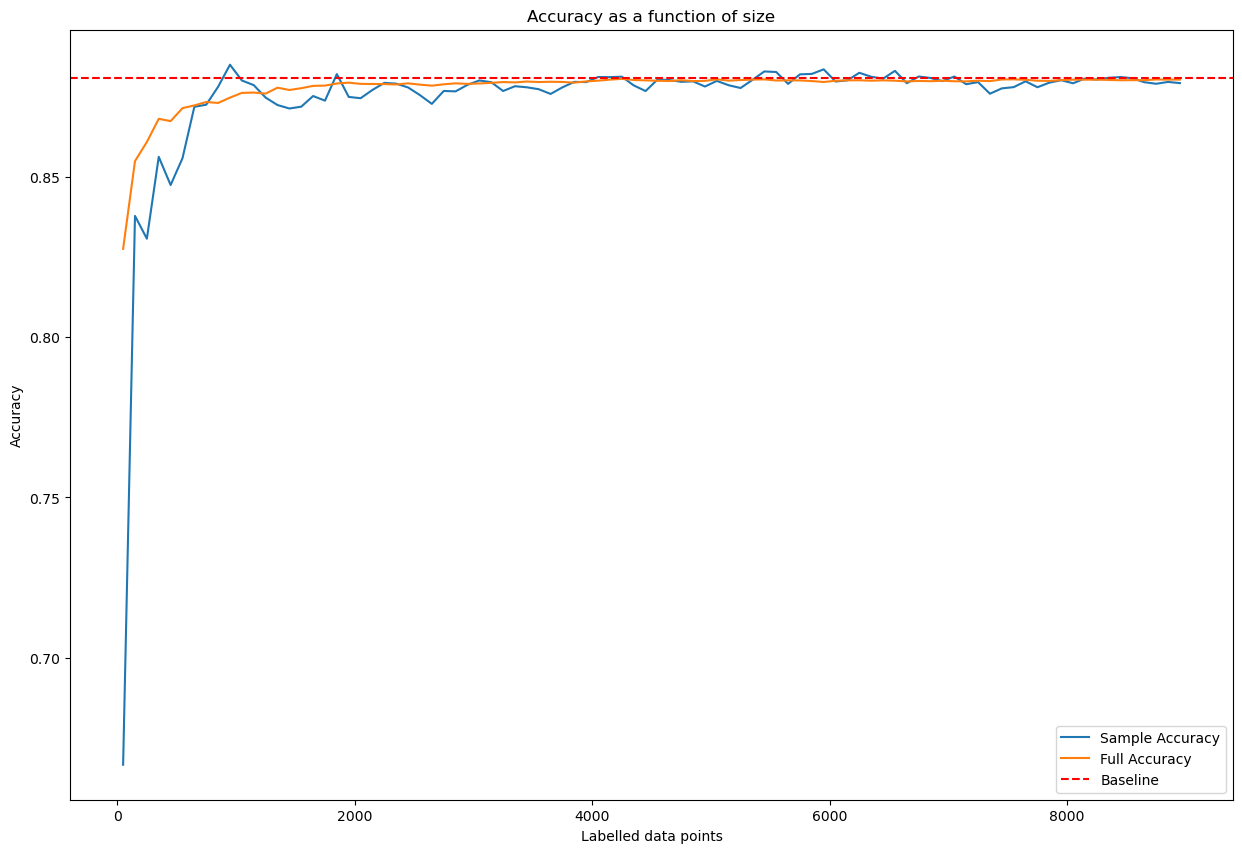

In [15]:
import matplotlib.pyplot as plt

plt.figure(figsize=(15,10))

plt.plot(accuracies_df.reset_index()['index'], accuracies_df['Sample Accuracy'], label='Sample Accuracy')
plt.plot(accuracies_df.reset_index()['index'], accuracies_df['Full Accuracy'], label='Full Accuracy')

# Baseline accuracy
plt.axhline(y=baseline_accuracy, color='r', linestyle='--', label='Baseline')

plt.legend()
plt.title('Accuracy as a function of size')
plt.xlabel('Labelled data points')
plt.ylabel('Accuracy')

plt.show()

### **Uncertainty Based Active Learning**

In [21]:
accuracies_u = {}

# Initialize sample (stratified)
_, current_sample = train_test_split(df, test_size=50, random_state=42, stratify=df['Suitable'])
labelled_indexes = current_sample.index.tolist()
step = 100

for size in range(50, 9000, step):
    
    # Select labelled data and train model
    labelled_df = df.loc[labelled_indexes]
    sample_acc, model, scaler = classificationModel(labelled_df)

    # Predict on unlabelled data
    unlabelled_df = df.drop(labelled_indexes)
    full_X_train_scaled = scaler.fit_transform(unlabelled_df.drop('Suitable', axis=1))
    full_y_pred = model.predict(full_X_train_scaled)
    full_acc = accuracy_score(unlabelled_df['Suitable'], full_y_pred)

    # Store accuracies
    accuracies_u[size] = [sample_acc, full_acc]
    
    # Update sample  -- Uncertainty based
    predicted_proba = model.predict_proba(full_X_train_scaled)
    predicted_proba_df = pd.DataFrame(predicted_proba[:,1], index=unlabelled_df.index)
    predicted_proba_df['uncertainty_diff'] = (0.5 - predicted_proba_df[0]).abs()

    top_50_uncertain_points = predicted_proba_df.nsmallest(step, 'uncertainty_diff')

    # Update labelled_indexes with the indexes of the top 50 uncertain points
    labelled_indexes.extend(top_50_uncertain_points.index.tolist())

In [22]:
accuracies_u_df = pd.DataFrame(accuracies_u).T
accuracies_u_df.columns = ['Sample Accuracy', 'Full Accuracy']
accuracies_u_df

,Sample Accuracy,Full Accuracy
50,0.666667,0.827514
150,0.800000,0.831617
250,0.786667,0.859258
350,0.809524,0.860793
450,0.777778,0.863516
...,...,...
8550,0.722417,0.874325
8650,0.713295,0.874439
8750,0.710857,0.874663
8850,0.706968,0.874942


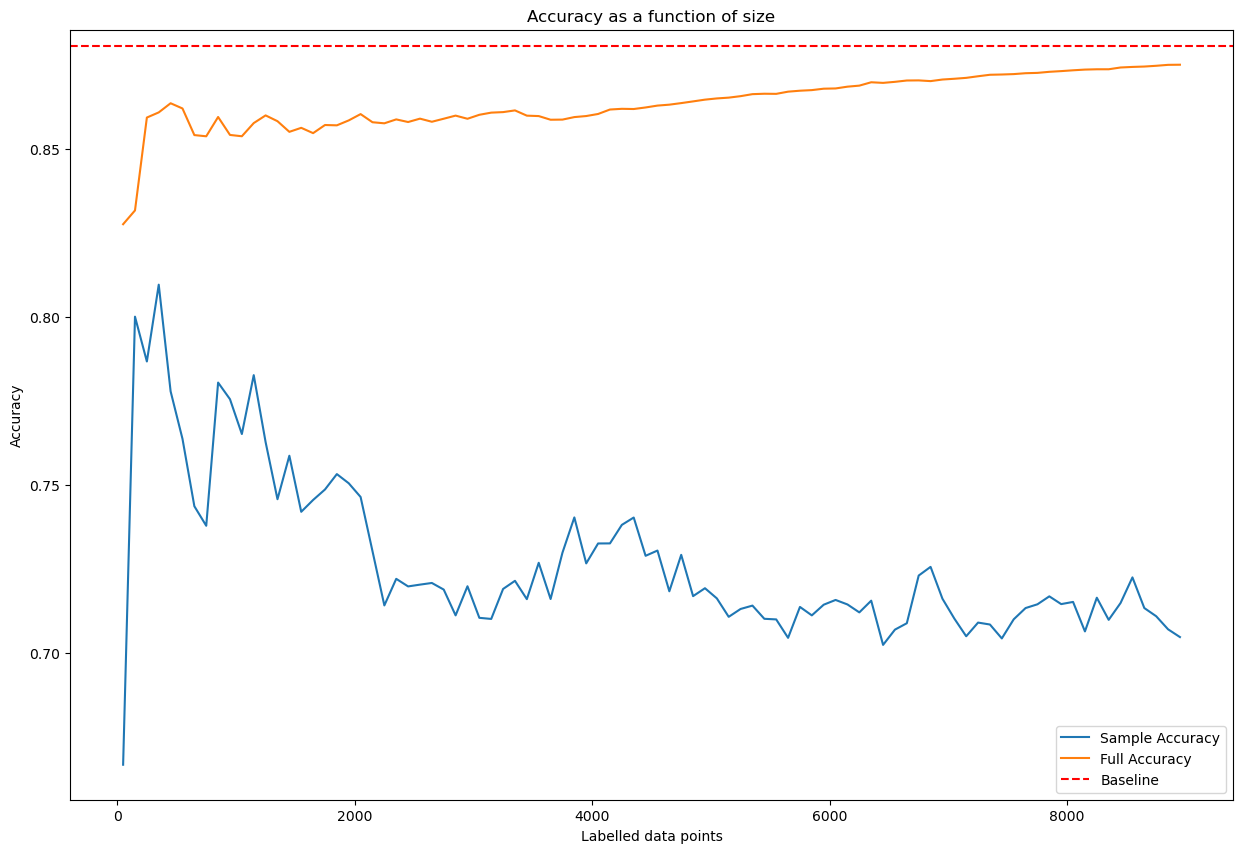

In [23]:
import matplotlib.pyplot as plt

plt.figure(figsize=(15,10))

plt.plot(accuracies_u_df.reset_index()['index'], accuracies_u_df['Sample Accuracy'], label='Sample Accuracy')
plt.plot(accuracies_u_df.reset_index()['index'], accuracies_u_df['Full Accuracy'], label='Full Accuracy')

# Baseline accuracy
plt.axhline(y=baseline_accuracy, color='r', linestyle='--', label='Baseline')

plt.legend()
plt.title('Accuracy as a function of size')
plt.xlabel('Labelled data points')
plt.ylabel('Accuracy')

plt.show()

### **Feature Selection and Uncertainty Based Active Learning**

In [24]:
from sklearn.metrics import accuracy_score
from scipy.spatial.distance import cdist

accuracies_uf = {}

# Initialize sample (stratified)
_, current_sample = train_test_split(df, test_size=50, random_state=42, stratify=df['Suitable'])
labelled_indexes = current_sample.index.tolist()
step = 100

for size in range(50, 9000, step):
    
    # Select labelled data and train model
    labelled_df = df.loc[labelled_indexes]
    sample_acc, model, scaler = classificationModel(labelled_df)

    # Predict on unlabelled data
    unlabelled_df = df.drop(labelled_indexes)
    unlabelled_X = unlabelled_df.drop('Suitable', axis=1)
    full_X_train_scaled = scaler.transform(unlabelled_X)
    full_y_pred = model.predict(full_X_train_scaled)
    full_acc = accuracy_score(unlabelled_df['Suitable'], full_y_pred)

    # Store accuracies
    accuracies_uf[size] = [sample_acc, full_acc]
    
    # Uncertainty based selection
    predicted_proba = model.predict_proba(full_X_train_scaled)
    predicted_proba_df = pd.DataFrame(predicted_proba[:,1], index=unlabelled_df.index)
    predicted_proba_df['uncertainty_diff'] = (0.5 - predicted_proba_df[0]).abs()
    uncertain_points = predicted_proba_df.nsmallest(step, 'uncertainty_diff')

    # Dissimilarity based selection
    uncertain_features = unlabelled_X.loc[uncertain_points.index]
    distances = cdist(unlabelled_X, uncertain_features, metric='euclidean')
    mean_distances = distances.mean(axis=1)
    dissimilarity_df = pd.DataFrame(mean_distances, index=unlabelled_df.index, columns=['dissimilarity'])
    dissimilar_points = dissimilarity_df.nlargest(step, 'dissimilarity')

    # Combine uncertain and dissimilar points
    combined_indexes = set(uncertain_points.index.tolist()).union(set(dissimilar_points.index.tolist()))

    # Update labelled_indexes with the combined indexes
    labelled_indexes.extend(combined_indexes)

accuracies_uf_df = pd.DataFrame(accuracies_uf).T
accuracies_uf_df.columns = ['Sample Accuracy', 'Full Accuracy']


In [25]:
accuracies_uf_df

,Sample Accuracy,Full Accuracy
50,0.666667,0.827864
150,0.826667,0.841383
250,0.866667,0.862019
350,0.774359,0.859819
450,0.811765,0.860535
...,...,...
8550,0.749951,0.887465
8650,0.751691,0.888136
8750,0.749570,0.888870
8850,0.748631,0.889462


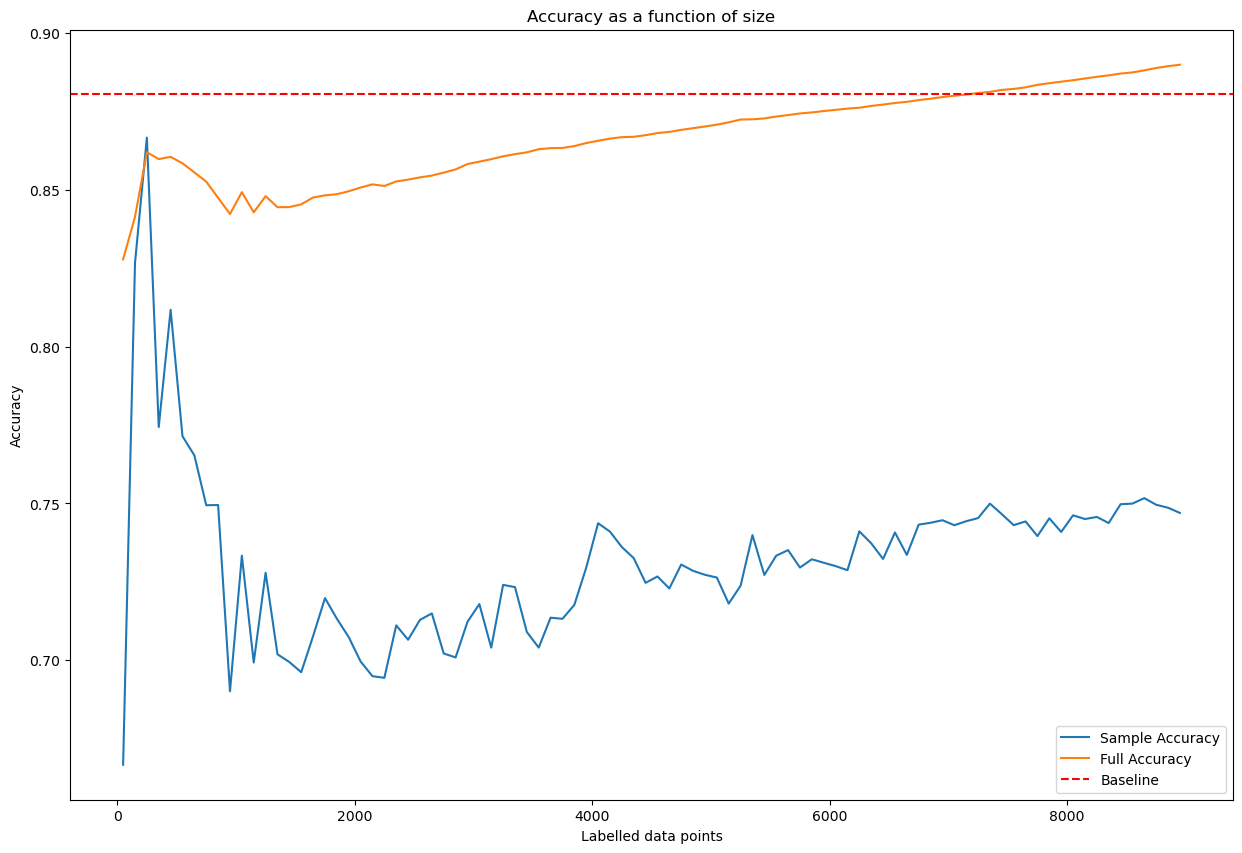

In [26]:
plt.figure(figsize=(15,10))

plt.plot(accuracies_uf_df.reset_index()['index'], accuracies_uf_df['Sample Accuracy'], label='Sample Accuracy')
plt.plot(accuracies_uf_df.reset_index()['index'], accuracies_uf_df['Full Accuracy'], label='Full Accuracy')

# Baseline accuracy
plt.axhline(y=baseline_accuracy, color='r', linestyle='--', label='Baseline')

plt.legend()
plt.title('Accuracy as a function of size')
plt.xlabel('Labelled data points')
plt.ylabel('Accuracy')

plt.show()